# Neural inference for SIRS model

$S \overset{k_I}{\longrightarrow} I \overset{k_R}{\longrightarrow} R \overset{k_S}{\longrightarrow} S$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import xarray as xr

from enum import IntEnum
from typing import Union

# Local import
from include import neural_net

%matplotlib inline

In [4]:
# Define an enum for the parameters and compartments so we are sure to always index in a consistent way
class Parameters(IntEnum):
    S = 0
    I = 1
    R = 2

class Compartments(IntEnum):
    S = 0
    I = 1
    R = 2

In [39]:
# Generate the data X and solve the ode
def generate_X_data(*,
        parameters: Union[dict, torch.Tensor],
        num_steps: int,
        init_state: torch.Tensor,
        dt: torch.Tensor = 1,
) -> torch.Tensor:
    
    """ Forward Euler solver for the recovery model. Parameters can be passed either as a dictionary of tensors, each of shape (L, 1) or as a tensor of shape (L, p). If L=1 the parameters are interpreted as constant, else as a time series. If L > 1 it must be at least equal to num_steps (L>=num_steps). """
    
    # Single Euler step
    def _step(_state, _params):
        return torch.clip(
            _state + torch.stack([
            -_params[Parameters["I"].value] * _state[Compartments["S"].value] * _state[Compartments["I"].value] + _params[Parameters["R"]] * _state[Compartments["R"].value],
            _params[Parameters["I"].value] * _state[Compartments["S"].value] * _state[Compartments["I"].value] - _params[Parameters["R"]] * _state[Compartments["I"].value],
            _params[Parameters["R"]] * _state[Compartments["I"].value] - _params[Parameters["S"]] * _state[Compartments["R"].value]
        ]) * dt, 0, 1)
    
    # Convert dict to tensor
    if isinstance(parameters, dict):
        parameters = torch.stack([parameters[key] for key in [e.name for e in Parameters]])
    
    # Initial state
    data = [init_state]
    
    for t in range(num_steps):        
        
        if parameters.shape[0] > 1:
            data.append(_step(data[-1], parameters[t]))
        else:
            data.append(_step(data[-1], parameters[0]))

    # Return the time series
    return torch.stack(data)

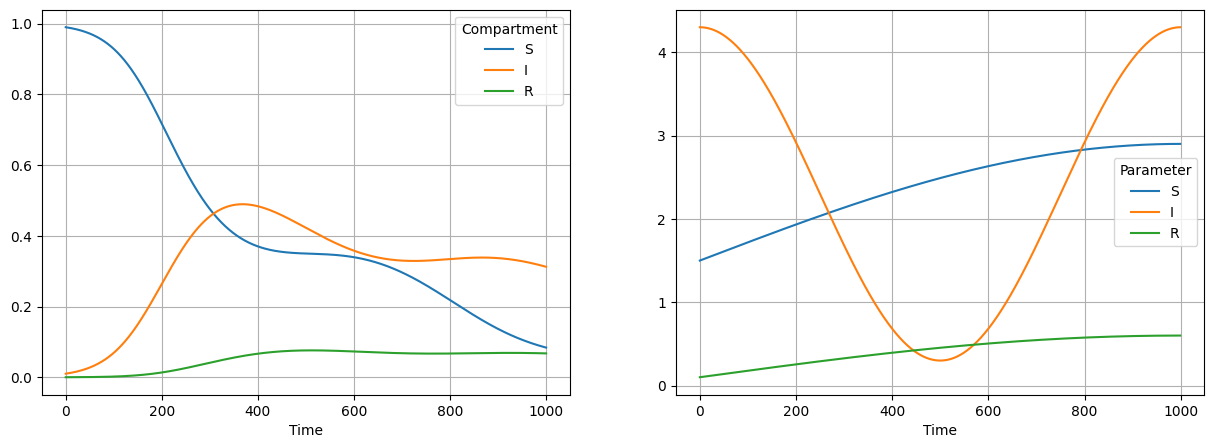

In [40]:
# Generate some training data
dt = torch.tensor(0.005)
num_steps = 1000

# Initial state
init_state = torch.tensor([0.99, 0.01, 0])

# Time series of oscillating parameters
true_params = torch.stack([
    torch.tensor([1.4 * torch.sin(n*dt * 0.1 * torch.pi) + 1.5 for n in range(num_steps)]),
    torch.tensor([2 * torch.cos(n*dt * 0.4 * torch.pi) + 2.3 for n in range(num_steps)]),
    torch.tensor([0.5 * torch.sin(n*dt * 0.1 * torch.pi) + 0.1 for n in range(num_steps)])
]).transpose(1, 0)

# Generate training data
X = generate_X_data(parameters=true_params, num_steps=num_steps, init_state=init_state, dt=dt)

# Plot
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
xr.DataArray(X, 
             dims=["Time", "Compartment"], 
             coords={"Time": np.arange(X.shape[0]), "Compartment": [e.name for e in Compartments]}
             ).plot(hue="Compartment", ax=axs[0])
xr.DataArray(true_params,
             dims = ["Time", "Parameter"], 
             coords= {"Time": np.arange(true_params.shape[0]), "Parameter": [e.name for e in Parameters]}).plot(hue="Parameter", ax=axs[1])
for ax in axs:
    ax.grid()

In [41]:
# Initialise the neural network
NN = neural_net.NeuralNet(
    input_size = 6, # Two time series points
    output_size = 3, # Number of parameters
    num_layers = 5,
    nodes_per_layer={"default": 20}, 
    activation_funcs={"default": "tanh", "layer_specific": {-1: "softplus"}}, 
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training loss
loss_ts = []

In [42]:
# Single training epoch
def epoch(training_X):
    
    # Make a prediction 
    predicted_params = NN(torch.hstack([training_X[:-1], training_X[1:]]))
    
    # Generate a time series
    predicted_time_series = generate_X_data(parameters=predicted_params, init_state=init_state, num_steps=num_steps, dt=dt)
    
    # Calculate gradient of loss
    loss = torch.nn.functional.mse_loss(predicted_time_series, training_X)
    loss.backward()
    
    # Can clip the gradients to prevent large oscillations (usually not necessary though)
    torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm=1)
    
    # Step
    NN.optimizer.step()
    NN.optimizer.zero_grad()
    
    return loss.detach()

In [51]:
for i in (pbar := tqdm.trange(4000)):
    _l = epoch(X)
    loss_ts.append(_l)
    pbar.set_description(f"Current loss: {_l}")

Current loss: 4.896153768640943e-05:   7%|▋         | 277/4000 [00:32<07:12,  8.62it/s] 


KeyboardInterrupt: 

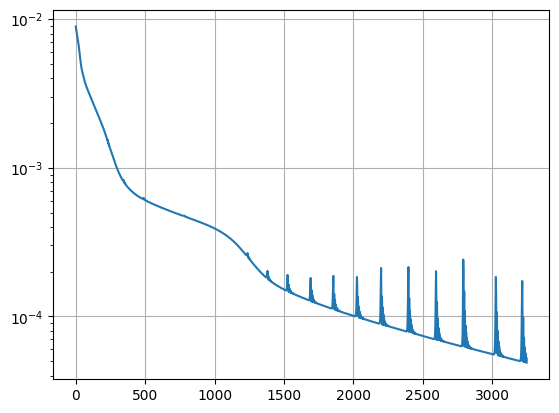

In [52]:
plt.plot(loss_ts[100:])
plt.yscale('log')
plt.grid()

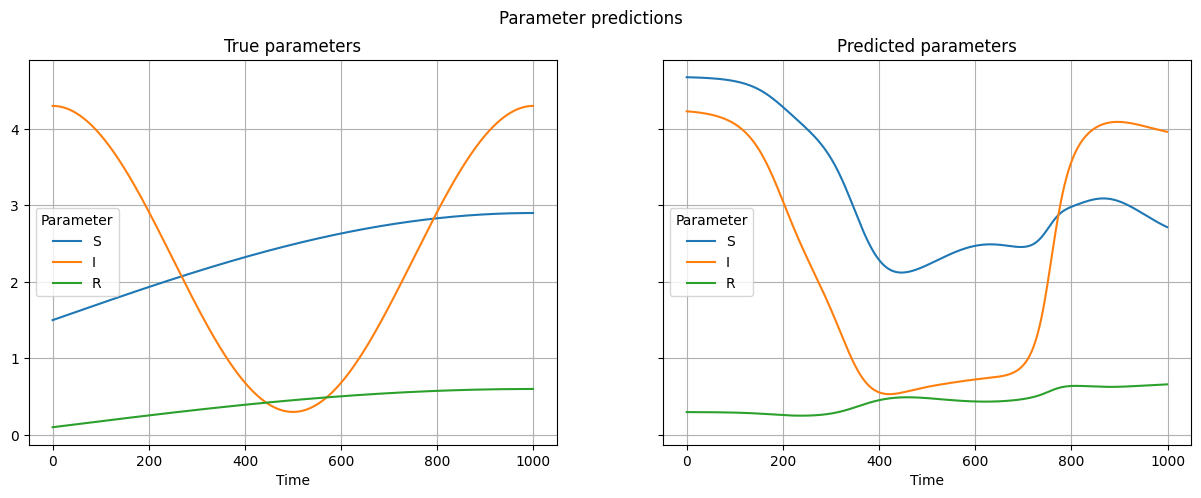

In [53]:
# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
xr.DataArray(true_params, dims = ["Time", "Parameter"], coords= {"Time": np.arange(true_params.shape[0]), "Parameter": [e.name for e in Parameters]}).plot(hue="Parameter", ax=axs[0])
xr.DataArray(NN(torch.hstack([X[:-1], X[1:]])).detach(), dims=["Time", "Parameter"], coords={"Time": np.arange(X.shape[0]-1), "Parameter": [e.name for e in Parameters]}).plot(hue="Parameter", ax=axs[1])
axs[0].set_title("True parameters")
axs[1].set_title("Predicted parameters")
fig.suptitle("Parameter predictions")
for ax in axs:
    ax.grid()

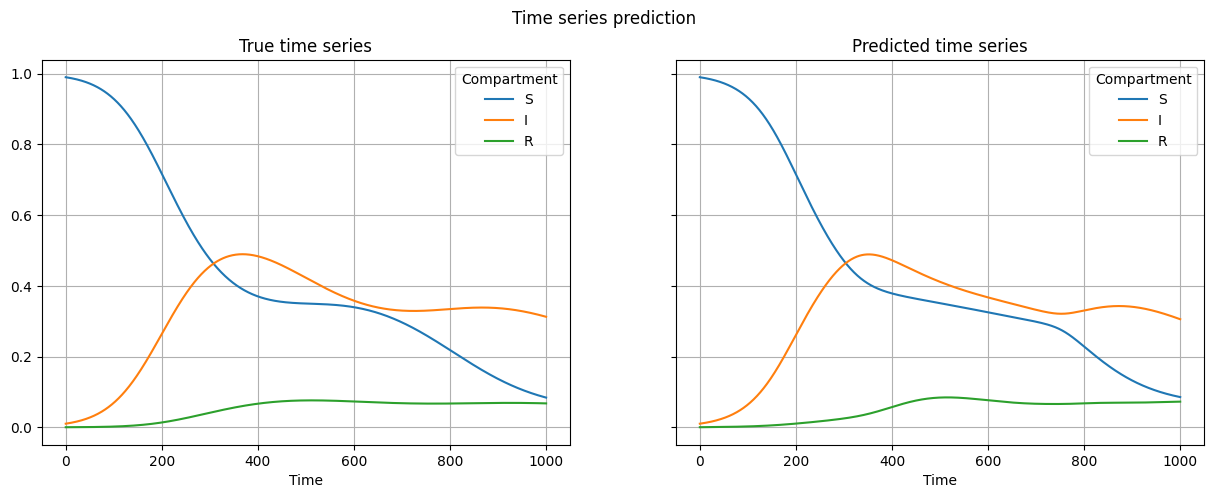

In [54]:
# Plot the resulting time series
fig, axs = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
xr.DataArray(X, dims=["Time", "Compartment"], coords={"Time": np.arange(X.shape[0]), "Compartment": [e.name for e in Compartments]}).plot(hue="Compartment", ax=axs[0])
xr.DataArray(generate_X_data(parameters=NN(torch.hstack([X[:-1], X[1:]])).detach(), init_state=init_state, dt=dt, num_steps=num_steps), dims=["Time", "Compartment"], coords={"Time": np.arange(X.shape[0]), "Compartment": [e.name for e in Compartments]}).plot(hue="Compartment", ax=axs[1])
axs[0].set_title("True time series")
axs[1].set_title("Predicted time series")
fig.suptitle("Time series prediction")
for ax in axs:
    ax.grid()